## KNN Temperature

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import sem
from scipy.stats import t

In [8]:
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)

In [17]:
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
temp_annual_mean = temp_reduced.reshape(-1, 1).flatten()
tmax_annual_mean = tmax_reduced.reshape(-1, 1).flatten()
tmin_annual_mean = tmin_reduced.reshape(-1, 1).flatten()

1276576 1276576 1276576


In [20]:
# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = temp.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1884, 2023), x * y)

data_dict = {
    'Year': years_expanded,
    'Temperature': temp_annual_mean,
    'Maximum Temperature': tmax_annual_mean,
    'Minimum Temperature': tmin_annual_mean
}
print(len(years_expanded))

1276576


In [21]:
df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

      Temperature  Maximum Temperature  Minimum Temperature      Class
Year                                                                  
1884     6.950380            10.900596             3.138283   pre_1990
1884     6.604088            10.432849             2.901733   pre_1990
1884     5.954602             9.636578             2.450827   pre_1990
1884     6.962700             9.609509             4.750815   pre_1990
1884     6.361767             9.031652             4.420964   pre_1990
...           ...                  ...                  ...        ...
2022     9.321733            13.045972             5.536837  post_1990
2022    10.583754            14.600538             6.504058  post_1990
2022    11.064243            15.244807             6.879631  post_1990
2022    10.834170            14.879905             6.772055  post_1990
2022     8.720055            12.152005             5.342153  post_1990

[237151 rows x 4 columns]


In [39]:
X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

scores = cross_val_score(knn, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)

0.7544643798359723
              precision    recall  f1-score   support

           0       0.49      0.36      0.41     11429
           1       0.81      0.88      0.84     36002

    accuracy                           0.75     47431
   macro avg       0.65      0.62      0.63     47431
weighted avg       0.73      0.75      0.74     47431

Training Set Score: 0.8568
Test Set Score: 0.7545
Average Accuracy: 0.7505
95% Confidence Interval: (0.7286992364013762, 0.7723949388039095)


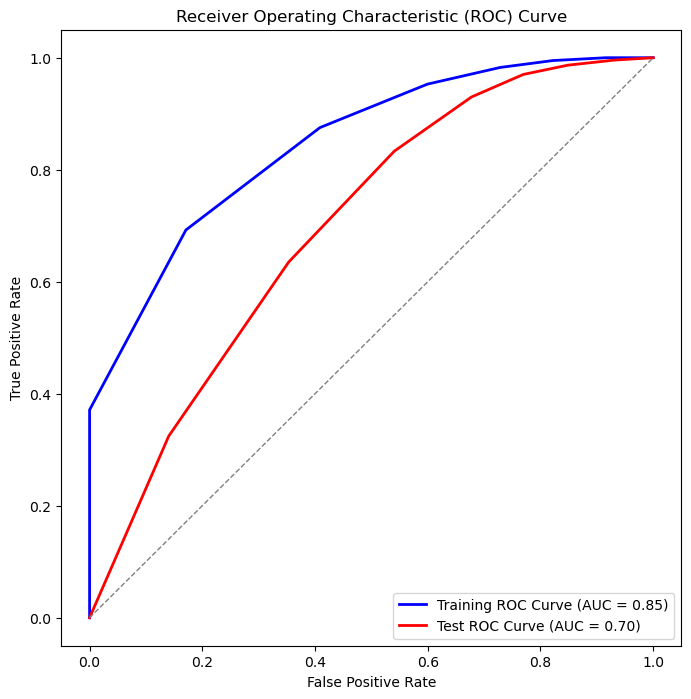

In [33]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

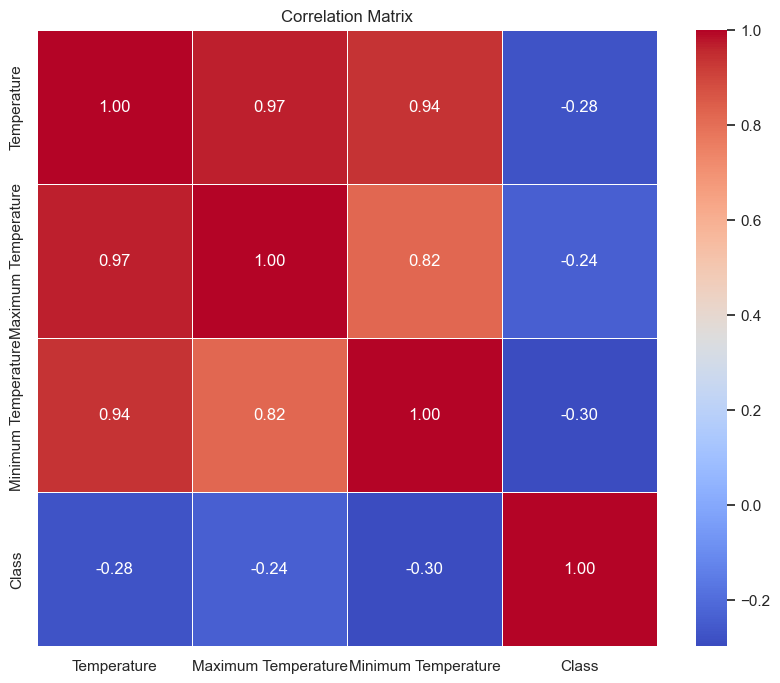

In [34]:
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

correlation_matrix = df.corr()
sns.set(style="white")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

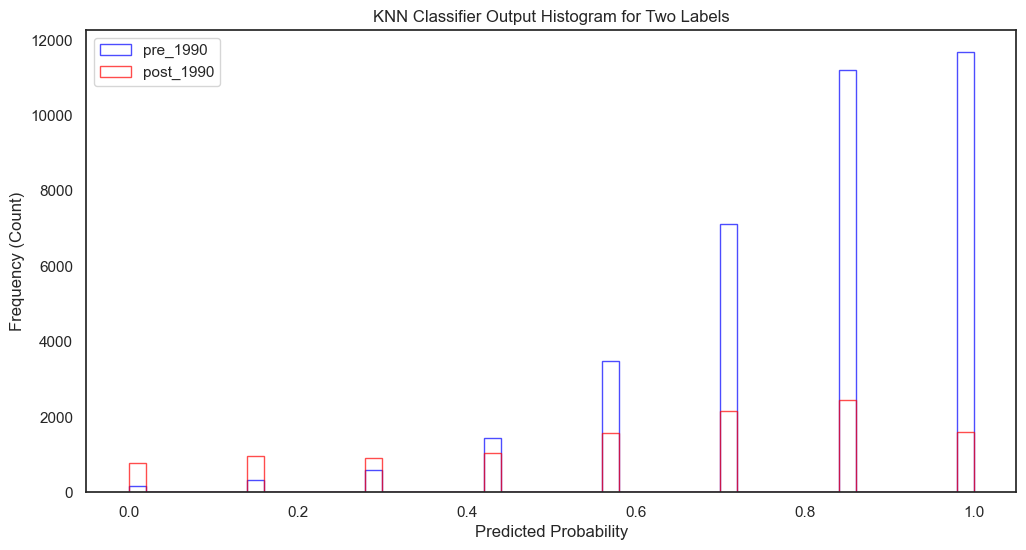

In [35]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

# Specify the two labels for which you want to create histograms
label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')

plt.title('KNN Classifier Output Histogram for Two Labels')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()
